In [2]:
# Imports
import numpy as np
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint as sp_randint
import sklearn
import lightgbm as lgb  # brew install lightgbm (on MacOS)
import pickle
from IPython.display import Image
from subprocess import call

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_graphviz
from sklearn.utils import resample

# Load data

In [3]:
train = pd.read_csv(os.path.join("cs5228", "train.csv"))
print(train.shape)

(24421, 14)


In [4]:
# Dealing with imbalanced classes

# separate minority and majority classes
lowincome = train[train.exceeds50K==0]
highincome = train[train.exceeds50K==1]

# downsample majority
lowincome_downsampled = resample(lowincome,
                                replace = False, # sample without replacement
                                n_samples = len(highincome), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([lowincome_downsampled, highincome])

# checking counts
downsampled.exceeds50K.value_counts()

1    5861
0    5861
Name: exceeds50K, dtype: int64

# Preprocessing

In [9]:
X_train = downsampled.drop(["exceeds50K"], axis=1)
y_train = downsampled["exceeds50K"]
X_test = pd.read_csv(os.path.join("cs5228", "test.csv"))
print(list(X_train.columns))
print(X_train.shape, X_test.shape)

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
(11722, 13) (24421, 13)


In [10]:
# One-hot-encoding
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
print(X_train.shape, X_test.shape)

(11722, 102) (24421, 103)


In [11]:
# issue: one country 'native-country_ Holand-Netherlands' in test but not in train
X_test2 = X_test.drop(['native-country_ Holand-Netherlands'], axis=1).copy()

In [12]:
del X_test

# Parameter optimisation: gridsearch using 5-fold CV for evaluation

In [ ]:
## Create a parameter grid for gridsearch

# Create the random grid
random_grid = {
    'objective': ['binary'],
    'num_leaves': [5, 10, 20, 50], 
    'min_data_in_leaf': [0, 10, 20, 40],
    'max_depth': [5, 10, 15],
    'max_bin': [5, 10, 25, 50],
    'learning_rate':[0.001, 0.01, 0.1],
    'dart': [True, False],
    'reg_alpha': [0, 1e-2, 1e-1, 1, 10, 100],
    'reg_lambda': [0, 1e-2, 1e-1, 1, 10, 100],
    'n_estimators': [1000, 5000, 10000],
    'bootstrap': [True, False]
        }
               
print(random_grid)

In [ ]:
## Use the random grid to search for best hyperparameters

# First create the base model to tune
gb = lgb.LGBMClassifier()
# Random search of parameters, using 3 fold cross validation, search across n_iter different combinations, and use all available cores
gb_gridsearch = RandomizedSearchCV(estimator=gb, param_distributions=random_grid, n_jobs=2,
                                   scoring="f1_weighted", n_iter=2000, cv=5, verbose=6, random_state=42)
# Fit the random searfch model
gb_gridsearch.fit(X_train, y_train)
# Print best parameters according to gridsearch
gb_gridsearch.best_params_

In [21]:
## Evaluate improvment between the base model and the fine-tuned model
# 0.8173340769377951 0.007585348588558676

# 0.8458570386361028 0.005887383462650146

base_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
cv_score_base = cross_val_score(base_model, X_train, y_train, cv=5, verbose=6, scoring='f1_macro')
print(cv_score_base.mean(), cv_score_base.std())

best_params = {
    'reg_lambda': 100,
    'reg_alpha': 0.1,
    'objective': 'binary',
    'num_leaves': 10,
    'n_estimators': 10000,
    'min_data_in_leaf': 20,
    'max_depth': 5,
    'max_bin': 50,
    'learning_rate': 0.01,
    'dart': False,
    'bootstrap': False,
    'class_weight': 'balanced'
}
# best_model = gb_gridsearch.best_estimator_
best_model = lgb.LGBMClassifier(**best_params, random_state=42)
cv_score_best = cross_val_score(best_model, X_train, y_train, cv=5, verbose=6, scoring='f1_macro')
print(cv_score_best.mean(), cv_score_best.std())

print('Improvement of {:0.2f}%.'.format(100 * (cv_score_best.mean() - cv_score_base.mean()) / cv_score_base.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.836, total=   0.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... , score=0.845, total=   0.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] .................................... , score=0.845, total=   0.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


[CV] .................................... , score=0.853, total=   0.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


[CV] .................................... , score=0.838, total=   0.3s
0.84328424234422 0.006151079237918454
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.839, total=   5.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


[CV] .................................... , score=0.851, total=   5.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s


[CV] .................................... , score=0.847, total=   5.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.7s remaining:    0.0s


[CV] .................................... , score=0.853, total=   6.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   24.6s remaining:    0.0s


[CV] .................................... , score=0.843, total=   7.1s
0.8464529975374855 0.005196832163136941
Improvement of 0.38%.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.8s finished


In [13]:
best_params = {
    'reg_lambda': 100,
    'reg_alpha': 0.1,
    'objective': 'binary',
    'num_leaves': 10,
    'n_estimators': 10000,
    'min_data_in_leaf': 20,
    'max_depth': 5,
    'max_bin': 50,
    'learning_rate': 0.01,
    'dart': False,
    'bootstrap': False,
    'class_weight': 'balanced'
}

# Train on whole dataset using optimised set of parameters

In [14]:
# final_model = lgb.LGBMClassifier(**gb_gridsearch.best_params_, random_state=42
final_model = lgb.LGBMClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', bootstrap=False, class_weight='balanced',
               colsample_bytree=1.0, dart=False, importance_type='split',
               learning_rate=0.01, max_bin=50, max_depth=5,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=20, min_split_gain=0.0, n_estimators=10000,
               n_jobs=-1, num_leaves=10, objective='binary', random_state=42,
               reg_alpha=0.1, reg_lambda=100, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

# Predict on test and save

In [ ]:
# issue: one country 'native-country_ Holand-Netherlands' in test but not in train
X_test = X_test.drop('native-country_ Holand-Netherlands', axis=1)

,prediction
id,
1,0
2,0
3,0
4,1
5,0


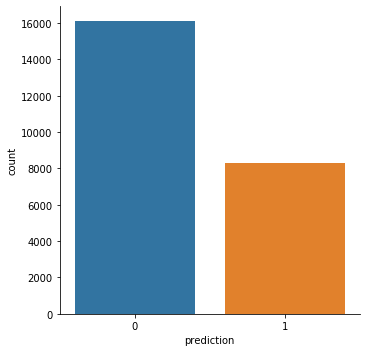

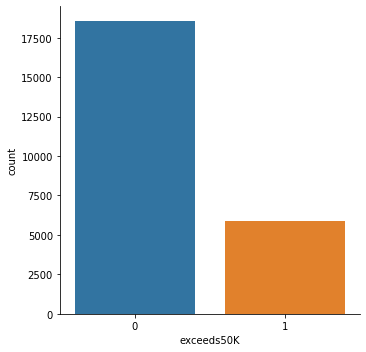

In [16]:
y_test = final_model.predict(X_test2)

res = {}
res["prediction"] = y_test
df = pd.DataFrame(res)
df.index += 1
df.index.name = 'id'
sns.catplot(x="prediction", kind="count", data=df)
sns.catplot(x="exceeds50K", kind="count", data=train)
df.head()

In [18]:
# experience name
experience = 'LightGBM_downsample'

if not os.path.exists(os.path.join('dump', experience)):
    os.mkdir(os.path.join('dump', experience))

X_train.to_csv(os.path.join('dump', experience, 'X_train.csv'))
X_test2.to_csv(os.path.join('dump', experience, 'X_test.csv'))
pickle.dump(final_model, open(os.path.join('dump', experience, 'model'), 'wb'))
df.to_csv(os.path.join('dump', experience, experience+'.csv'))

# Feature importance

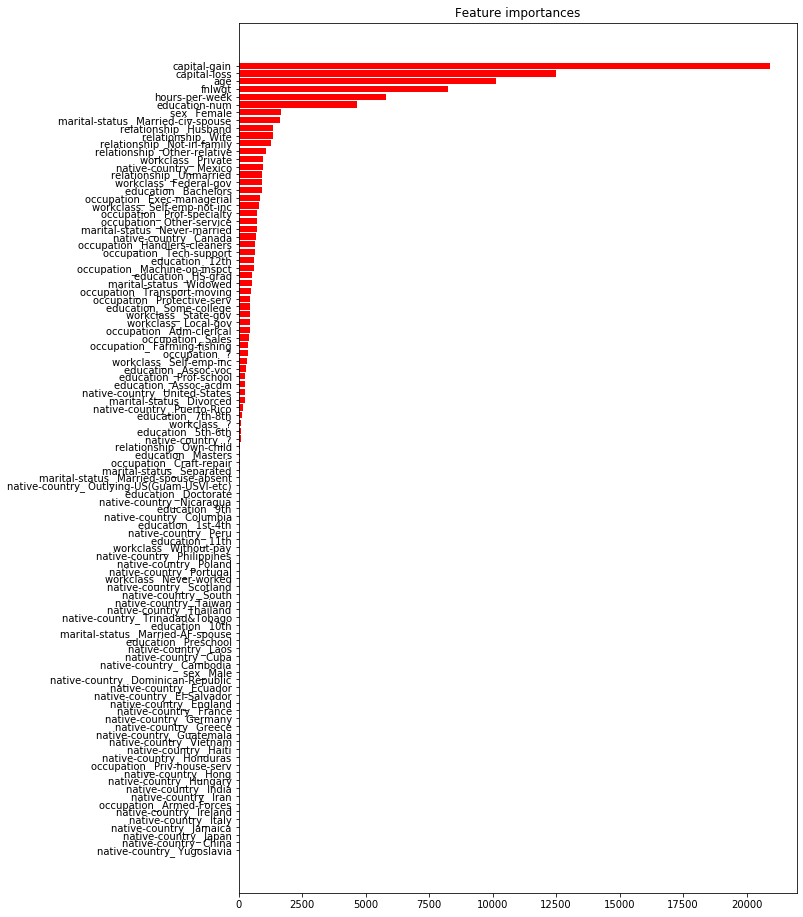

In [19]:
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]
colnames = list(X_train)

fig, ax = plt.subplots(1, 1, figsize=(10,16))
ax.set_title("Feature importances")
ax.barh(range(len(colnames)), importances[indices[::-1]],
        color="r", align="center")
ax.set_yticks(range(len(colnames)))
ax.set_yticklabels(np.array(colnames)[indices][::-1])
plt.show()

In [20]:
experience = 'LightGBM_downsample'
X_train = pd.read_csv(os.path.join('dump', experience, 'X_train.csv'), index_col=0)
final_model = pickle.load(open(os.path.join('dump', experience, 'model'), 'rb'))
lgb.create_tree_digraph(final_model).save(directory=os.path.join('dump', experience), filename='tree.dot')
call(['dot', '-Tpng', os.path.join('dump', experience, 'tree.dot'),
      '-o', os.path.join('dump', experience, 'tree.png'), '-Gdpi=600'])
# Display in jupyter notebook
Image(filename = os.path.join('dump', experience, 'tree.png'))

ImportError: You must install graphviz to plot tree.